In [3]:
%load_ext autoreload
%autoreload 2

import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\troy\\Documents\\Code\\Libraries', 'C:\\Users\\troy\\Documents\\Excel Sheets', 'C:/Users/troy/Documents/Code/Libraries'])
from datetime import date, datetime
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import autoreload

import dash_bootstrap_components as dbc
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output

from tia.bbg import LocalTerminal

Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)] on win32


In [74]:
start_date = date(2020, 12, 1)
end_date = date(2021, 12, 31)

ticker = "USSW5 Curncy"
fields = ['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST']

resp = LocalTerminal.get_historical(ticker, fields, start_date, end_date)
data = resp.as_frame()[ticker]

In [102]:
close = data.loc[date(2020, 12, 31):, 'PX_LAST']

cumm_chg = close - close[0]
drawdown = cumm_chg.cummax() - cumm_chg
max_drawdown = drawdown.max()

buy_and_hold_pnl_bps = cumm_chg[-1] * 100
buy_and_hold_pnl_bps

93.95

In [80]:
daily_chg = close.diff().fillna(0) *100
print(max(daily_chg), np.percentile(daily_chg, 90), np.percentile(daily_chg, 75), np.percentile(daily_chg, 50), np.percentile(daily_chg, 25), np.percentile(daily_chg, 10), min(daily_chg))

daily_chg2 = daily_chg.copy()
daily_chg2[daily_chg2>np.percentile(daily_chg2, 96.5)] = 0
np.sum(daily_chg2), buy_and_hold_pnl_bps

17.94 4.611000000000002 2.0725000000000047 0.2949999999999897 -1.5750000000000015 -3.6869999999999936 -18.889999999999986


(-3.989999999999993, 93.95)

In [81]:
fomc = [(1, 25, 29), (3, 15, 19), (4, 26, 30), (6, 14, 18), (7, 26, 30), (9, 20, 24), (11, 1, 5), (12, 13, 17)]
fomc_weekdates = []
for m, d1, d2 in fomc:
    for i in range(d1, d2+1):
        fomc_weekdates.append(date(2021, m, i))

cpi_dates = [(1, 13), (2, 10), (3, 10), (4, 13), (5, 12), (6, 10), (7, 13), (8, 11), (9, 14), (10, 13), (11, 10), (12, 10)]
cpi_dates = [date(2021, m, d) for m, d in cpi_dates]

nfp_dates = [(1, 8), (2, 5), (3, 5), (4, 2), (5, 7), (6, 4), (7, 2), (8, 6), (9, 3), (10, 8), (11, 5), (12, 3)]
nfp_dates = [date(2021, m, d) for m, d in nfp_dates]

daily_chg = close.diff().fillna(0) *100

daily_chg3 = daily_chg.copy()
daily_chg3[fomc_weekdates] = 0
np.sum(daily_chg3), buy_and_hold_pnl_bps

# Impact of CPI dates
daily_chg3 = daily_chg.copy()
daily_chg3[cpi_dates] = 0
np.sum(daily_chg3), buy_and_hold_pnl_bps

# Impact of NFP dates
daily_chg3 = daily_chg.copy()
daily_chg3[nfp_dates] = 0
np.sum(daily_chg3), buy_and_hold_pnl_bps

daily_chg[cpi_dates], daily_chg[cpi_dates].cumsum()

(date
 2021-01-13    -3.37
 2021-02-10    -2.41
 2021-03-10    -1.45
 2021-04-13    -5.24
 2021-05-12     6.42
 2021-06-10    -3.52
 2021-07-13     5.49
 2021-08-11    -2.08
 2021-09-14    -1.51
 2021-10-13    -0.84
 2021-11-10    12.90
 2021-12-10    -2.02
 Name: PX_LAST, dtype: float64,
 date
 2021-01-13    -3.37
 2021-02-10    -5.78
 2021-03-10    -7.23
 2021-04-13   -12.47
 2021-05-12    -6.05
 2021-06-10    -9.57
 2021-07-13    -4.08
 2021-08-11    -6.16
 2021-09-14    -7.67
 2021-10-13    -8.51
 2021-11-10     4.39
 2021-12-10     2.37
 Name: PX_LAST, dtype: float64)

## Vol Control

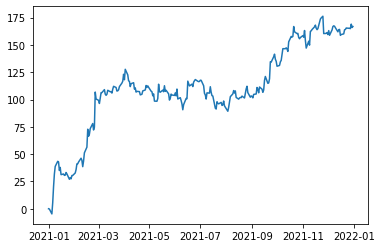

In [101]:
daily_chg = close.diff().fillna(0) *100

close_vol = data['PX_LAST'].diff().fillna(0).rolling(20).std()
target_vol = 0.04
pos = target_vol / close_vol[date(2020, 12, 31):]
wgts = pos.shift(1).fillna(1)
base_risk = 300000 / (4 * target_vol * 100)

wgt_chgs = daily_chg * wgts
plt.plot(wgt_chgs.cumsum())
